In [246]:
import pandas as pd
import numpy as np

In [247]:
f1 = './data/nasa_19950731.22-19950831.22.tsv_result_file.csv'

In [280]:
original_data = pd.read_csv(f1, low_memory=False)

In [281]:
original_data.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response
0,in24.inetnebr.com,in24.inetnebr.com_1,31-07-1995,10:30:01,GET,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt,200
1,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:07,GET,/,304
2,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/ksclogo-medium.gif,304
3,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/MOSAIC-logosmall.gif,304
4,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/USA-logosmall.gif,304


In [282]:
html_requests = original_data[original_data['url'].str.contains("html")]

In [384]:
html_requests.shape

(333447, 8)

In [284]:
def extract_domain(host):
    # Exceptions: list of domain suffixes that need to be handled differently
    try:
        l = host.split('.')
        try:
            a = int(l[-1])
            return host
        except:
            return f'{l[-2]}.{l[-1]}'
    except:
        return host

In [285]:
html_requests['domain'] = html_requests['host'].apply(extract_domain)

/var/folders/zy/wtk5xtjj3ys94jw0_p7ghk8m0000gn/T/ipykernel_29427/3607411476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  html_requests['domain'] = html_requests['host'].apply(extract_domain)


In [286]:
from collections import defaultdict
import pandas as pd


# Build Markov chain model
def build_markov_chain(df):
    sessions = defaultdict(list)
    for _, row in df.iterrows():
        session_id = row['sessionID']
        url = row['url']
        sessions[session_id].append(url)
    
    transitions = defaultdict(lambda: defaultdict(int))
    for urls_sequence in sessions.values():
        for i in range(len(urls_sequence) - 1):
            current_url = urls_sequence[i]
            next_url = urls_sequence[i + 1]
            transitions[current_url][next_url] += 1
    
    # Convert transition counts to probabilities
    markov_chain = defaultdict(dict)
    for current_url, next_urls in transitions.items():
        total_transitions = sum(next_urls.values())
        for next_url, count in next_urls.items():
            markov_chain[current_url][next_url] = count / total_transitions
    
    return markov_chain

# Predict next URL using Markov chain
def predict_next_url(markov_chain, current_url):
    next_urls = markov_chain.get(current_url, {})
    if next_urls:
        next_url = max(next_urls, key=next_urls.get)
        probability = next_urls[next_url]
        return (next_url, probability)
    else:
        return (None, 0)  # No transition from current URL


In [287]:
# example usage
markov_chain = build_markov_chain(html_requests)

In [288]:
current = []
next = []
probability = []

In [289]:
for point in html_requests.url.unique():
    next_url, prob = predict_next_url(markov_chain, point)
    current.append(point)
    next.append(next_url)
    probability.append(prob)
        

In [290]:
# Predict next URL for a given current URL
current_url = '/shuttle/missions/sts-69/movies/movies.html'  # Example current URL
next_url = predict_next_url(markov_chain, current_url)
print("Predicted next URL:", next_url)

Predicted next URL: ('/shuttle/missions/sts-69/images/images.html', 0.2524977293369664)


In [259]:
predictions = pd.DataFrame({'Current': current, 'Next':next, 'Probability': probability})

In [260]:
final = pd.merge(html_requests, predictions, left_on='url', right_on='Current', how='inner')

In [261]:
final.to_csv('./data/final_nasa_19950731.22-19950831.22.csv')

In [262]:
chains = []

In [263]:
for link in current:
    queue = []
    queue.append(link)
    t = [link]
    s = set()
    while(queue):
        x = predict_next_url(markov_chain, queue[0])
        if(x==None or x in s):
            chains.append(t)
            queue.clear()
        else:
            s.add(x)
            t.append(x)
            queue.clear()
            queue.append(x)

In [264]:
predictions

,Current,Next,Probability
0,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706
1,/shuttle/missions/sts-69/mission-sts-69.html,/shuttle/resources/orbiters/endeavour.html,0.175067
2,/history/apollo/apollo-16/apollo-16.html,/history/apollo/apollo-16/apollo-16-info.html,0.333333
3,/shuttle/resources/orbiters/discovery.html,/shuttle/resources/orbiters/endeavour.html,0.164069
4,/history/skylab/skylab-1.html,/history/skylab/skylab-2.html,0.475410
...,...,...,...
1300,/payloads/processing/vpart2.html,/payloads/processing/vpart2.html,0.500000
1301,/payloads/processing/vpart11.html,/payloads/processing/vpart11.html,0.944444
1302,/payloads/processing/vpart0.html,/payloads/processing/vpart0.html,0.500000
1303,/shuttle/missions/sts-69/images/contact69.html,/shuttle/missions/sts-69/images/contact69.html,0.947368


In [265]:
from collections import Counter

In [266]:
types = Counter()
for curr in final.Current.values:
    c = curr.split('/')
    for i in c:
        types[i]+=1
del types['']

In [267]:
types.most_common(10)

[('shuttle', 187076),
 ('missions', 127330),
 ('history', 58453),
 ('ksc.html', 43821),
 ('sts-69', 40936),
 ('apollo', 35107),
 ('technology', 29149),
 ('sts-newsref', 29138),
 ('mission-sts-69.html', 24626),
 ('missions.html', 22488)]

In [268]:
# Example
markov_chain['/history/skylab/skylab.html']

{'/history/skylab/skylab-1.html': 0.21370604147880973,
 '/history/skylab/skylab-2.html': 0.1704238052299369,
 '/facilities/lcc.html': 0.002705139765554554,
 '/history/skylab/skylab.html': 0.027051397655545536,
 '/history/skylab/skylab-4.html': 0.15058611361587015,
 '/history/history.html': 0.09467989179440937,
 '/shuttle/missions/missions.html': 0.046889089269612265,
 '/shuttle/missions/sts-71/mission-sts-71.html': 0.0018034265103697023,
 '/shuttle/missions/sts-70/movies/movies.html': 0.0018034265103697023,
 '/history/apollo/apollo-16/apollo-16-info.html': 0.0009017132551848512,
 '/shuttle/technology/sts-newsref/stsref-toc.html': 0.0009017132551848512,
 '/history/apollo/apollo.html': 0.04869251577998197,
 '/history/skylab/skylab-3.html': 0.03787195671776375,
 '/history/mercury/mercury.html': 0.02164111812443643,
 '/shuttle/missions/sts-1/mission-sts-1.html': 0.0018034265103697023,
 '/shuttle/missions/41-b/mission-41-b.html': 0.0009017132551848512,
 '/ksc.html': 0.06492335437330929,
 ':

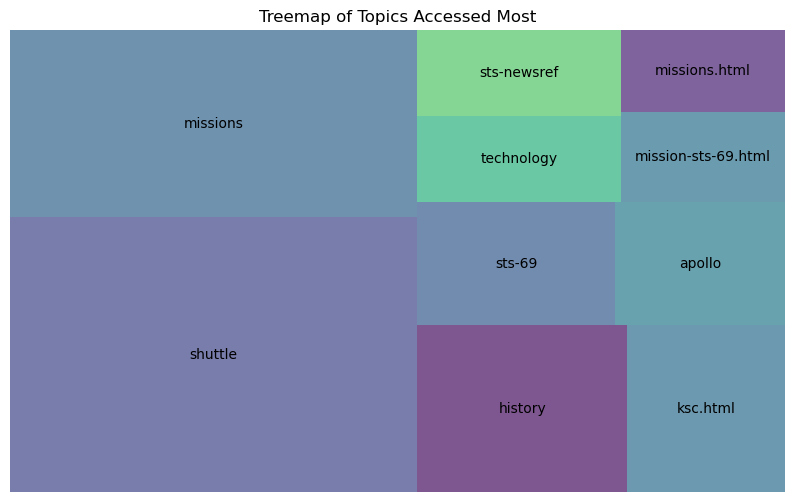

In [269]:
import matplotlib.pyplot as plt
import squarify

# Data
data = types.most_common(10)

# Extract labels and sizes
labels = [item[0] for item in data]
sizes = [item[1] for item in data]

# Plot treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.7)
plt.axis('off')
plt.title('Treemap of Topics Accessed Most')
plt.show()


In [270]:
df = final.copy()

In [271]:
def is_history(value):
    if 'hist' in value.lower():
        return 1
    else:
        return 0
def is_shuttle(value):
    if 'shutt' in value.lower():
        return 1
    else:
        return 0
def is_missions(value):
    if 'mission' in value.lower():
        return 1
    else:
        return 0
def is_ksc(value):
    if 'ksc' in value.lower():
        return 1
    else:
        return 0
def is_sts(value):
    if 'sts' in value.lower():
        return 1
    else:
        return 0

In [272]:
df['history'] = df['Current'].apply(is_history)
df['shuttle'] = df['Current'].apply(is_shuttle)
df['missions'] = df['Current'].apply(is_missions)
df['ksc'] = df['Current'].apply(is_ksc)
df['sts'] = df['Current'].apply(is_sts)

In [273]:
df.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response,domain,Current,Next,Probability,history,shuttle,missions,ksc,sts
0,slppp6.intermind.net,slppp6.intermind.net_1,31-07-1995,10:30:10,GET,/history/skylab/skylab.html,200,intermind.net,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706,1,0,0,0,0
1,www-b5.proxy.aol.com,www-b5.proxy.aol.com_1,31-07-1995,11:01:04,GET,/history/skylab/skylab.html,200,aol.com,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706,1,0,0,0,0
2,h96-158.ccnet.com,h96-158.ccnet.com_1,31-07-1995,12:11:41,GET,/history/skylab/skylab.html,200,ccnet.com,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706,1,0,0,0,0
3,204.199.188.113,204.199.188.113_1,31-07-1995,12:18:59,GET,/history/skylab/skylab.html,200,204.199.188.113,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706,1,0,0,0,0
4,bettong.client.uq.oz.au,bettong.client.uq.oz.au_1,31-07-1995,12:31:24,GET,/history/skylab/skylab.html,200,oz.au,/history/skylab/skylab.html,/history/skylab/skylab-1.html,0.213706,1,0,0,0,0


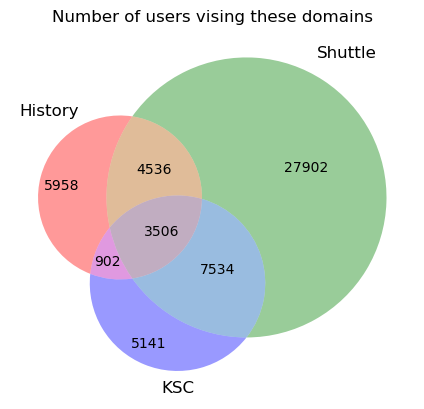

In [274]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3


# Create sets for Venn diagram
sets = {
    'history': set(df[df['history'] == 1]['host']),
    'shuttle': set(df[df['shuttle'] == 1]['host']),
    'missions': set(df[df['missions'] == 1]['host']),
    'ksc': set(df[df['ksc'] == 1]['host']),
    'sts': set(df[df['sts'] == 1]['host'])
}

# Plot Venn diagram
venn3([sets['history'], sets['shuttle'], sets['ksc']], ('History', 'Shuttle', 'KSC'))
plt.title('Number of users vising these domains')
plt.show()


In [291]:
dataset = pd.read_csv(f1, low_memory=False)

In [295]:
dataset.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response
0,in24.inetnebr.com,in24.inetnebr.com_1,31-07-1995,10:30:01,GET,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt,200
1,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:07,GET,/,304
2,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/ksclogo-medium.gif,304
3,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/MOSAIC-logosmall.gif,304
4,uplherc.upl.com,uplherc.upl.com_1,31-07-1995,10:30:08,GET,/images/USA-logosmall.gif,304


In [292]:
dataset[dataset['url'].str.contains('mp4')].count()

host                 2
sessionID            2
date (DD-MM-YYYY)    2
time (HH:MM:SS)      2
method               2
url                  2
 response            2
dtype: int64

In [293]:
dataset[~dataset['url'].str.contains(r'\.gif$|\.html$|\.jpeg$|\.jpg$|\.mp4$', regex=True, case=False)].count()

host                 257055
sessionID            257055
date (DD-MM-YYYY)    257055
time (HH:MM:SS)      257055
method               257055
url                  257055
 response            257055
dtype: int64

In [395]:
def get_actual_next_url(final, sessionID, current_url):
    session_data = final[final['sessionID'] == sessionID]
    urls = session_data['url'].tolist()
    if current_url in urls:
        index = urls.index(current_url)
        if index < len(urls) - 1:
            return urls[index + 1]
        else:
            return None  # No next URL
    else:
        return None  # Current URL not found in session

# # Example usage
# next_url = get_actual_next_url(df, 'slppp6.intermind.net_1', '/history/skylab/skylab.html')
# print("Next URL:", next_url)


In [418]:
x = []

In [419]:
c=0
for idx, row in final.iterrows():
    c+=1
    if(c<=20000):
        n = get_actual_next_url(final, row['sessionID'], row['url'])
        x.append(n)
    else:
        break

In [420]:
len(x)

20000

In [421]:
first_20000 = final.iloc[:20000, :].Next.to_list()

In [423]:
tr = 0
fa = 0
for i in range(len(x)):
    if(x[i]==first_20000[i]):
        tr+=1
    else:
        fa+=1

In [424]:
tr/ (tr+fa)

0.11005